
# Linear regression example using Spike-Slab Prior

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution. The problem is solved via sampling using emcee.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# local imports (inference data post-processing)
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

We start by generating a synthetic data set from a known linear model to which we will
add some noise.



In [2]:
# ground truth that is to be inferred
a_true = 8
b_true = 10

# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1 # is assumed to be known and is not inferred.

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test + b_true #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



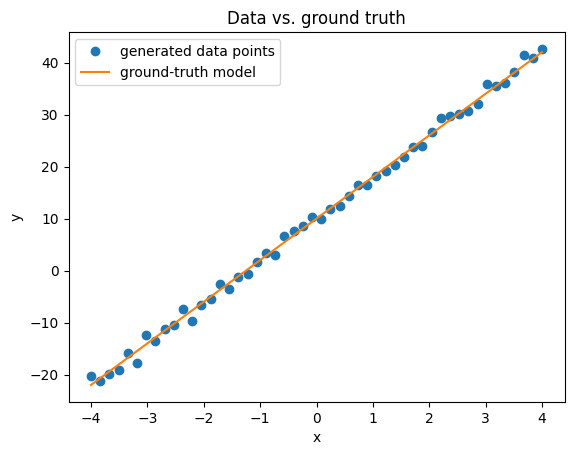

In [3]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
#plt.plot(x_test, - 2*x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Starting values for the parameters are selected using priors. Parameters.json file contatins the list of parameters and their definition.



In [4]:
import json
with open('parameters_relaxed_spikeslab.json', 'r') as f: 
    json_object = json.loads(f.read()) 

nwalkers = 20
ndim = len(json_object.get('parameters')) 
from scipy.stats import invgamma, halfcauchy, norm, bernoulli, uniform
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
        for hyperparameter in parameter['hyperparameters']:
            for ind, param in enumerate(json_object.get('parameters')):
                if hyperparameter == param['name']:
                    lmbda = start_parameters[:, ind]
        start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance1"], size=nwalkers) + (1 - lmbda)*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance2"], size=nwalkers)
    elif parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   


Defining the log likelihood, log prior functions and using emcee to run the inference problem.

In [5]:
def log_likelihood(theta, _x_test, _y_test, _sigma):
    # Model output - Change thetas over here if changes in parameters are made in json file.
    #if theta[0] >= 0.5:
    y_model = theta[1] * _x_test * _x_test + theta[3] * _x_test + theta[5]#10 * 
    #elif theta[0] < 0.5:
    #    theta[1] = 0
    #    y_model = 10
    return -0.5 * np.sum((_y_test - y_model) ** 2 / _sigma**2 + np.log(_sigma**2))

from scipy.stats import invgamma, halfcauchy, norm, bernoulli
import math

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Bernoulli':
            ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
            #if theta[index] >= 0.3:
            #    theta[index] = 1
            #else:
            #    theta[index] = 0
            if theta[index] < 0.0 or theta[index] > 1.0:
                return -np.inf
            _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
            #_lp += bernoulli.logpmf(theta[index], p = parameter['prior'][1]["p"])
        elif parameter['prior'][0] == 'Spike-Slab':
            for hyperparameter in parameter['hyperparameters']:
                for ind, param in enumerate(json_object.get('parameters')):
                    if hyperparameter == param['name']:
                        lmbda = theta[ind]
                        #if lmbda < 0.0 or lmbda > 1.0:
                        #    return -np.inf
            #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 
            #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
            #_lp += math.log(lmbda*norm.pdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance1"]) + (1 - lmbda)*norm.pdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance2"]))
            if lmbda <= 0.5:
                _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance2"])
            else:
                _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance1"])
        
        elif parameter['prior'][0] == 'Normal': 
            _lp[:, index] = norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 

        elif parameter['prior'][0] == 'Uniform':   
            _lp[:, index] = uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
    
    return _lp
            

def log_probability(theta, _x_test, _y_test, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, _x_test, _y_test, _std_noise)


sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_test, y_test, std_noise))
sampler.run_mcmc(start_parameters, 5000, progress=True)

100%|██████████| 5000/5000 [00:29<00:00, 168.72it/s]


State([[ 1.11179782e-02  1.07304527e-02  7.48283055e-01  8.01938571e+00
   6.63510932e-01  1.01773422e+01]
 [ 2.43564781e-01  1.39548973e-02  9.26304677e-01  7.98877337e+00
   9.28611819e-01  1.00917478e+01]
 [ 1.71538833e-01  1.62264693e-02  6.16875275e-01  8.07610492e+00
   6.11983198e-01  9.92881778e+00]
 [ 2.63489048e-01  1.99667070e-02  5.84433217e-01  8.00976391e+00
   7.64722399e-01  9.59219035e+00]
 [ 4.28664790e-01 -4.83744989e-03  8.79428591e-01  8.03007329e+00
   7.65223829e-01  1.01592809e+01]
 [ 2.58517951e-01  4.87701054e-03  7.04010137e-01  8.06747215e+00
   6.81405209e-01  9.94238301e+00]
 [ 1.83823429e-02 -1.38419960e-02  7.62230787e-01  7.98317291e+00
   8.57366692e-01  9.86109705e+00]
 [ 2.37460196e-01  8.47108895e-03  7.94713443e-01  8.07670472e+00
   7.94645288e-01  1.00675464e+01]
 [ 1.11502604e-02  4.83500608e-03  5.73198245e-01  7.98206189e+00
   9.96702945e-01  9.95127654e+00]
 [ 3.96812989e-01 -1.50143909e-03  9.32137941e-01  8.04830455e+00
   5.70478446e-01  

Plotting the trace of the chain

Text(0.5, 0, 'step number')

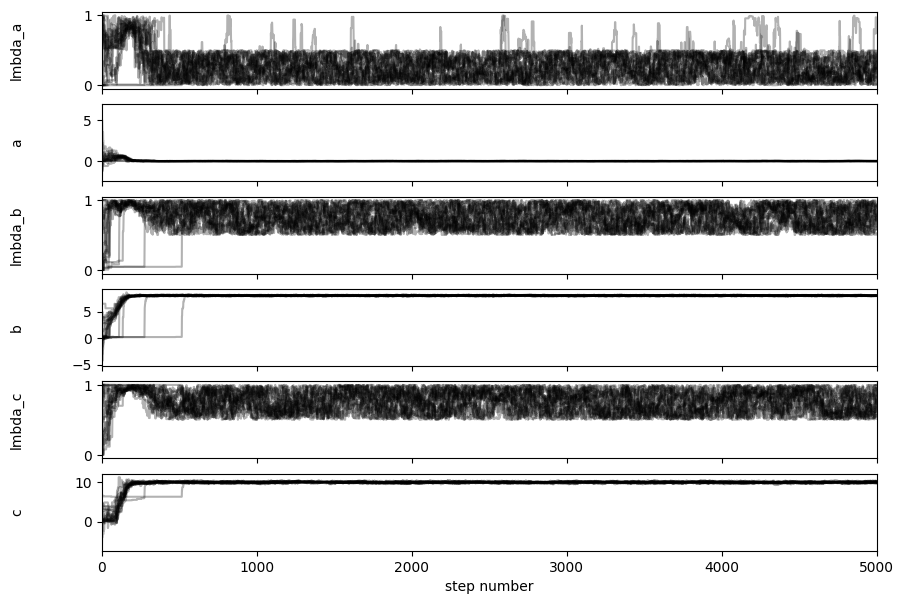

In [6]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Plotting the pair-plot of the chain.

In [7]:
flat_samples = sampler.get_chain(discard=4999)

In [9]:
flat_samples[:,:,[0,1]]

array([[[ 1.11179782e-02,  1.07304527e-02],
        [ 2.43564781e-01,  1.39548973e-02],
        [ 1.71538833e-01,  1.62264693e-02],
        [ 2.63489048e-01,  1.99667070e-02],
        [ 4.28664790e-01, -4.83744989e-03],
        [ 2.58517951e-01,  4.87701054e-03],
        [ 1.83823429e-02, -1.38419960e-02],
        [ 2.37460196e-01,  8.47108895e-03],
        [ 1.11502604e-02,  4.83500608e-03],
        [ 3.96812989e-01, -1.50143909e-03],
        [ 1.86694142e-01,  4.38315942e-03],
        [ 1.12749437e-01, -1.05718556e-02],
        [ 3.70585265e-01,  4.40875666e-03],
        [ 7.88424181e-01,  1.02758148e-02],
        [ 4.84431933e-01,  1.87871514e-02],
        [ 3.35598931e-01, -7.79214775e-03],
        [ 6.58611200e-02,  3.11793754e-03],
        [ 4.57072065e-01,  9.71277498e-03],
        [ 1.79915352e-01, -5.92511639e-04],
        [ 1.13461424e-01,  1.91555233e-03]]])

In [ ]:
flat_samples[:, 13, :]

In [ ]:
flat_samples[:,7,:]

In [ ]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)
import corner
labels = ["lmbda_a", "a", "lmbda_b", "b"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 8, 1, 10]
)